<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4000 non-null   object 
 1   age                3893 non-null   float64
 2   hypertension       3770 non-null   float64
 3   heart_disease      3910 non-null   float64
 4   ever_married       4000 non-null   object 
 5   work_type          4000 non-null   object 
 6   Residence_type     4000 non-null   object 
 7   avg_glucose_level  3829 non-null   float64
 8   bmi                2884 non-null   float64
 9   smoking_status     4000 non-null   object 
 10  blood              3990 non-null   object 
 11  height             2928 non-null   float64
 12  stroke             4000 non-null   int64  
dtypes: float64(6), int64(1), object(6)
memory usage: 406.4+ KB
Value counts: 

Female    2218
Male      1625
Other      157
Name: gender, dtype: int64


52.00    78
57.00  

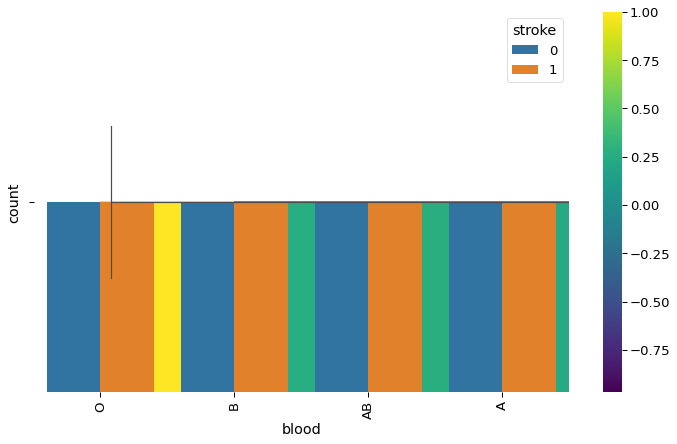

In [445]:
## Import package

import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

## Read dataset

raw_df = pd.read_csv('./Dataset/train.csv')
raw_df.head()

# Drop `id` feature because it's useless

df = raw_df.copy()
df.drop(columns=['id'], inplace=True)
df

## Analyze Data

df.describe().transpose()

df.info()

def draw_missing_data_table(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# sns.set(style="ticks");
# pal = ["#FA5858", "#58D3F7"]

# sns.pairplot(df, hue="stroke", palette=pal);
# plt.title("stroke");

df.corr()["stroke"].sort_values(ascending=False)

df.corr()["bmi"].sort_values(ascending=False)

plt.figure(figsize=(12,7))
sns.set_context("paper", font_scale=1.5)
sns.heatmap(df.corr(), cmap="viridis")

sns.boxplot(x='avg_glucose_level',data=df, color='Red')

sns.boxplot(x='bmi',data=df, color = 'Green')

df.loc[df['bmi'] > 45]

sns.boxplot(x='age',data=df , color = 'Blue')

df.columns

# unknown_feature = ['gender', 'hypertension', 'heart_disease', 'Residence_type', 'smoking_status','ever_married', 'blood', 'work_type', 'stroke']
unknown_feature = df.columns
print('Value counts: \n')
for i in unknown_feature:
    print(df[i].value_counts())
    print('\n')

print('Value percent: ')
for i in unknown_feature:
    print(df[i].value_counts(normalize=True)*100)
    print('\n')

## Preprocessing Data

### fill 'age' and 'bmi' mean values

df['age'] = df['age'].fillna(np.mean(df['age']))
df

labels = [1,2,3,4,5]
df["age_bin"] = pd.cut(df["age"], 5, labels=labels)
df['age_bin'].value_counts()

gb_bmi = df.groupby("age_bin")["bmi"].mean()
gb_bmi

def impute_bmi(cols):
    bmi = cols[0]
    age_bin = cols[1]
    
    if pd.isnull(bmi):
        if age_bin == 1:
            return 20.715509
        elif age_bin == 2:
            return 28.814368
        elif age_bin == 3:
            return 31.020136
        elif age_bin == 4:
            return 31.480000
        elif age_bin == 5:
            return 29.288200
    else:
        return bmi

df["bmi"] = df[["bmi","age_bin"]].apply(impute_bmi, axis=1)
df['bmi']

draw_missing_data_table(df)

df.describe()

# Xoá dữ liệu có `bmi` <= 45

df = df.loc[df['bmi'] < 45]
df



draw_missing_data_table(df)

## Drop height

df.drop(columns=['height'], inplace=True)

df.head()

draw_missing_data_table(df)

## Check correlation for avg_glucose_level

df.corr()['avg_glucose_level'].sort_values(ascending=False)

### Hmm, this isn't really that much correlation so mean all time

df['avg_glucose_level'] = df['avg_glucose_level'].fillna(np.mean(df['avg_glucose_level']))

df.head()

draw_missing_data_table(df)

## Fill hypertension and blood with the one that has the most value count

df['hypertension'] = df['hypertension'].fillna(0.0)
df['hypertension'] = df['hypertension'].astype(int)
df.head()

draw_missing_data_table(df)

df['heart_disease'] = df['heart_disease'].fillna(0.0)
df['heart_disease'] = df['heart_disease'].astype(int)
df.head()

draw_missing_data_table(df)

sns.countplot(x=df['blood'], hue=df['stroke'])

df['blood'] = df['blood'].fillna('AB')

df.head()

df['Residence_type'].unique()
df.loc[df['Residence_type']=='Unknown']

# - We will convert ever_married to 0 and 1
# - We will one-hot-encode work_type, avg_glucose_level, blood
# - We will drop Residence_type
# - smoking_status????

df.drop(columns='age_bin', inplace=True)

df

for i in df.columns:
    print(str(i) + '= ' + str(df[i].unique()))

marriage_mapping = {'No': 0, 'Yes': 1}
df['ever_married'] = df['ever_married'].map(marriage_mapping)

df.head()

oh = OneHotEncoder()

categorical_features_oh = ['gender', 'blood', 'smoking_status', 'Residence_type', 'work_type']

for i in categorical_features_oh:
    df[i] = pd.Categorical(df[i])
    dfDummies = pd.get_dummies(df[i], prefix= i)
    df = pd.concat([df, dfDummies], axis=1)
df

for i in categorical_features_oh:
    df.drop(columns=i, axis=1, inplace=True)
df

draw_missing_data_table(df)

from sklearn.preprocessing import StandardScaler
std = StandardScaler()
columns = ['avg_glucose_level','bmi','age']
scaled = std.fit_transform(df[columns])
scaled = pd.DataFrame(scaled,columns=columns)
df=df.drop(columns=columns,axis=1)

df = df.reset_index(drop=True)
df = df.merge(scaled, left_index=True, right_index=True, how = "left")
df

draw_missing_data_table(df)
df.to_csv('./Dataset/preprocessed_train.csv', index=False)
# x = df.copy()
# x = x.drop(columns='stroke')
# y = df['stroke']

# x[0:5]

# y[0:5]

# ## TREATING IMBALANCE CLASS USING SMOTE

# smote = SMOTE()
# x_smote, y_smote = smote.fit_resample(x, y)

# x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size= 0.2, random_state= 42)

# print(len(x_train))
# print(len(y_train))
# print(len(x_test))
# print(len(y_test))

# ## Training model

# ### Using XGBoost

# import xgboost as xgb
# model_xgb = xgb.XGBClassifier()
# model_xgb.fit(x_train, y_train)
# y_xgb_pred = model_xgb.predict(x_test)
# f1_score(y_test, y_xgb_pred)

# cm = confusion_matrix(y_test, y_xgb_pred)
# cm

# tn = cm[0,0]
# fp = cm[0,1]
# tp = cm[1,1]
# fn = cm[1,0]
# accuracy  = (tp + tn) / (tp + fp + tn + fn)
# precision = tp / (tp + fp)
# recall    = tp / (tp + fn)
# f1score  = 2 * precision * recall / (precision + recall)
# print(f1score)
# print(accuracy)

## Test submission

In [419]:
raw_df = pd.read_csv('./Dataset/public_test.csv')
raw_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,blood,height
0,67,Female,17.0,0.0,0.0,No,Private,Urban,92.97,NaN,formerly smoked,AB,NaN
1,210,Male,81.0,0.0,0.0,Yes,Self-employed,Rural,91.54,31.4,never smoked,A,1.60
2,242,Male,4.0,NaN,0.0,No,children,Urban,98.56,17.5,Unknown,O,NaN
3,711,Male,81.0,0.0,NaN,Yes,Private,Rural,92.96,22.2,never smoked,AB,NaN
4,724,Male,17.0,0.0,0.0,No,Private,Rural,81.77,44.7,never smoked,O,1.34


In [420]:
df = raw_df.copy()
df['age'] = df['age'].fillna(np.mean(df['age']))

In [421]:
labels = [1,2,3,4,5]
df["age_bin"] = pd.cut(df["age"], 5, labels=labels)
df['age_bin'].value_counts()

3    129
4    111
5     94
2     86
1     80
Name: age_bin, dtype: int64

In [422]:
gb_bmi = df.groupby("age_bin")["bmi"].mean()
gb_bmi

age_bin
1    21.190909
2    28.552632
3    32.482645
4    30.884000
5    29.695181
Name: bmi, dtype: float64

In [423]:
def impute_bmi(cols):
    bmi = cols[0]
    age_bin = cols[1]
    if pd.isnull(bmi):
        if age_bin == 1:
            return 21.190909
        elif age_bin == 2:
            return 28.552632
        elif age_bin == 3:
            return 32.456890
        elif age_bin == 4:
            return 30.884000
        elif age_bin == 5:
            return 29.695181
    else:
        return bmi

In [424]:
df["bmi"] = df[["bmi","age_bin"]].apply(impute_bmi, axis=1)
df['bmi']

0      28.552632
1      31.400000
2      17.500000
3      22.200000
4      44.700000
         ...    
495    24.200000
496    29.200000
497    32.800000
498    30.884000
499    17.600000
Name: bmi, Length: 500, dtype: float64

In [425]:
df = df.drop(['age_bin'],axis=1)
draw_missing_data_table(df)

,Total,Percent
heart_disease,134,0.268
height,124,0.248
hypertension,45,0.090
avg_glucose_level,6,0.012
blood,0,0.000
smoking_status,0,0.000
bmi,0,0.000
Residence_type,0,0.000
work_type,0,0.000
ever_married,0,0.000


In [426]:
df = df.drop(['height'],axis=1)

In [427]:
df['avg_glucose_level'] = df['avg_glucose_level'].fillna(np.mean(df['avg_glucose_level']))

In [428]:
unknown_feature = df.columns
print('Value counts: \n')
for i in unknown_feature:
    print(df[i].value_counts())
    print('\n')

Value counts: 

46079    1
8553     1
21830    1
37192    1
51532    1
        ..
12482    1
28367    1
66258    1
724      1
56322    1
Name: id, Length: 500, dtype: int64


Female    305
Male      175
Other      20
Name: gender, dtype: int64


54.00    13
43.00    12
37.00    12
66.00    11
40.00    11
         ..
1.48      1
1.72      1
9.00      1
0.72      1
1.80      1
Name: age, Length: 87, dtype: int64


0.0    404
1.0     51
Name: hypertension, dtype: int64


0.0    345
1.0     21
Name: heart_disease, dtype: int64


Yes    327
No     173
Name: ever_married, dtype: int64


Private          274
Self-employed     88
children          71
Govt_job          65
Never_worked       2
Name: work_type, dtype: int64


Urban      245
Rural      232
Unknown     23
Name: Residence_type, dtype: int64


106.47502    6
112.02000    2
90.11000     2
91.89000     2
81.51000     2
            ..
64.62000     1
56.90000     1
110.20000    1
93.72000     1
83.75000     1
Name: avg_glucose_level, Len

In [429]:
df['hypertension'] = df['hypertension'].fillna(0.0)
df['hypertension'] = df['hypertension'].astype(int)
df['heart_disease'] = df['heart_disease'].fillna(0)
df['heart_disease'] = df['heart_disease'].astype(int)

In [430]:
for i in df.columns:
    print(str(i) + '= ' + str(df[i].unique()))

id= [   67   210   242   711   724   751   841   917  1119  1192  1552  1847
  1953  2267  2304  2424  2456  2580  2647  2692  2818  3013  3318  3512
  3700  4148  4929  5170  5294  5647  5654  5714  5987  6202  6390  6422
  6472  6574  6599  6605  6625  6805  7047  7054  7538  7653  7841  7871
  7924  8022  8045  8122  8543  8553  8623  8920  8964  9189  9394 10018
 10056 10135 10166 10321 10696 10870 10950 11312 11325 11382 11632 11762
 11816 11872 11891 11908 11933 12345 12367 12482 12594 12668 12834 12857
 12900 12963 13031 13172 13237 13286 13540 13598 13768 13846 13902 14444
 14553 14658 14789 14892 14943 14996 15062 15422 15464 15978 16024 16263
 16320 16377 16446 16590 16617 16627 16629 16817 17098 17174 17238 17308
 17478 17569 18178 18283 18352 18398 18578 18696 18833 19498 19814 19907
 20237 20387 20426 20439 20979 21067 21110 21346 21366 21407 21677 21830
 22151 22282 22330 22515 22614 22880 23194 23210 23238 23339 23439 23449
 23568 23989 24106 24163 24246 24262 24421 2458

In [431]:
marriage_mapping = {'No': 0, 'Yes': 1}
df['ever_married'] = df['ever_married'].map(marriage_mapping)

In [432]:
oh = OneHotEncoder()

In [433]:
categorical_features_oh = ['gender', 'blood', 'smoking_status', 'Residence_type', 'work_type']

In [434]:
for i in categorical_features_oh:
    df[i] = pd.Categorical(df[i])
    dfDummies = pd.get_dummies(df[i], prefix= i)
    df = pd.concat([df, dfDummies], axis=1)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,blood,gender_Female,gender_Male,gender_Other,blood_A,blood_AB,blood_B,blood_O,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Unknown,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,67,Female,17.0,0,0,0,Private,Urban,92.97,28.552632,formerly smoked,AB,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,210,Male,81.0,0,0,1,Self-employed,Rural,91.54,31.400000,never smoked,A,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
2,242,Male,4.0,0,0,0,children,Urban,98.56,17.500000,Unknown,O,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
3,711,Male,81.0,0,0,1,Private,Rural,92.96,22.200000,never smoked,AB,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0
4,724,Male,17.0,0,0,0,Private,Rural,81.77,44.700000,never smoked,O,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,72393,Female,23.0,0,0,1,Govt_job,Rural,84.93,24.200000,never smoked,A,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
496,72491,Male,53.0,0,0,1,Private,Urban,74.66,29.200000,smokes,O,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0
497,72562,Female,57.0,0,0,1,Private,Rural,64.37,32.800000,never smoked,AB,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0
498,72792,Female,53.0,0,0,1,Private,Rural,77.94,30.884000,never smoked,AB,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0


In [435]:
for i in categorical_features_oh:
    df.drop(columns=i, axis=1, inplace=True)
df

,id,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,blood_A,blood_AB,blood_B,blood_O,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Unknown,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,67,17.0,0,0,0,92.97,28.552632,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,210,81.0,0,0,1,91.54,31.400000,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
2,242,4.0,0,0,0,98.56,17.500000,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
3,711,81.0,0,0,1,92.96,22.200000,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0
4,724,17.0,0,0,0,81.77,44.700000,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,72393,23.0,0,0,1,84.93,24.200000,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
496,72491,53.0,0,0,1,74.66,29.200000,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0
497,72562,57.0,0,0,1,64.37,32.800000,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0
498,72792,53.0,0,0,1,77.94,30.884000,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0


In [436]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
columns = ['avg_glucose_level','bmi','age']
scaled = std.fit_transform(df[columns])
scaled = pd.DataFrame(scaled,columns=columns)
df=df.drop(columns=columns,axis=1)

In [437]:
df = df.reset_index(drop=True)
df = df.merge(scaled, left_index=True, right_index=True, how = "left")
df

,id,hypertension,heart_disease,ever_married,gender_Female,gender_Male,gender_Other,blood_A,blood_AB,blood_B,blood_O,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Unknown,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,avg_glucose_level,bmi,age
0,67,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,-0.288097,-0.071492,-1.162120
1,210,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,-0.318603,0.286883,1.711148
2,242,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,-0.168848,-1.462595,-1.745753
3,711,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,-0.288311,-0.871045,1.711148
4,724,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,-0.527022,1.960843,-1.162120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,72393,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,-0.459611,-0.619321,-0.892751
496,72491,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,-0.678697,0.009987,0.454093
497,72562,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,-0.898210,0.463089,0.633672
498,72792,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,-0.608726,0.221938,0.454093


In [438]:
dir_path = "./Dataset/ouput_processed_test.csv"

In [439]:
df.to_csv(dir_path, index= False)

In [440]:
test_df = pd.read_csv(dir_path)
test_df

,id,hypertension,heart_disease,ever_married,gender_Female,gender_Male,gender_Other,blood_A,blood_AB,blood_B,blood_O,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Unknown,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,avg_glucose_level,bmi,age
0,67,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,-0.288097,-0.071492,-1.162120
1,210,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,-0.318603,0.286883,1.711148
2,242,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,-0.168848,-1.462595,-1.745753
3,711,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,-0.288311,-0.871045,1.711148
4,724,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,-0.527022,1.960843,-1.162120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,72393,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,-0.459611,-0.619321,-0.892751
496,72491,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,-0.678697,0.009987,0.454093
497,72562,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,-0.898210,0.463089,0.633672
498,72792,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,-0.608726,0.221938,0.454093


In [441]:
# test_df.drop(columns= 'Unnamed: 0', inplace=True)

In [442]:
x = test_df.copy()
x.drop(columns='id', inplace=True)
id_test = test_df['id']

In [443]:
x

,hypertension,heart_disease,ever_married,gender_Female,gender_Male,gender_Other,blood_A,blood_AB,blood_B,blood_O,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Rural,Residence_type_Unknown,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,avg_glucose_level,bmi,age
0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,-0.288097,-0.071492,-1.162120
1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,-0.318603,0.286883,1.711148
2,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,-0.168848,-1.462595,-1.745753
3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,-0.288311,-0.871045,1.711148
4,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,-0.527022,1.960843,-1.162120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,-0.459611,-0.619321,-0.892751
496,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,-0.678697,0.009987,0.454093
497,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,-0.898210,0.463089,0.633672
498,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,-0.608726,0.221938,0.454093


In [444]:
y_xgb_pred_test = model_xgb.predict(x)

ValueError: ignored

In [ ]:
y_xgb_pred_test

In [ ]:
data_test_submit = {'id': id_test, 'stroke': y_xgb_pred_test}
df_test_submit = pd.DataFrame(data= data_test_submit)
df_test_submit

In [ ]:
df_test_submit.to_csv('./Dataset/Submission.csv', index= False)

## Save Model

In [ ]:
from model_utils import save_model, load_model
save_model(model_xgb, './models/xgb')